In [606]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt


In [607]:
xls = pd.ExcelFile('../data/btc future and reference rate/chains of btc future last price.xlsx')

In [608]:
# Contract Month Codes
month_code = ['F', 'G', 'H', 'J', 'K', 'M', 'N', 'Q', 'U', 'V', 'X','Z']
month = [1,2,3,4,5,6,7,8,9,10,11,12]
month_dict = dict(zip(month_code, month))
month_dict

{'F': 1,
 'G': 2,
 'H': 3,
 'J': 4,
 'K': 5,
 'M': 6,
 'N': 7,
 'Q': 8,
 'U': 9,
 'V': 10,
 'X': 11,
 'Z': 12}

In [609]:
year = [2021, 2020, 2020, 2019, 2018]
year_code = ['1','0', '20', '19','18']
year_dict = dict(zip(year_code, year))

In [610]:
def last_Friday(y,m):
    day = dt.date(y,m,1)

    while day.weekday()!=4:
        day -= dt.timedelta(days=1)
    # Monday == 0 ... Sunday == 6
    last_Fri = day
    return last_Fri

In [611]:
df = pd.read_excel(xls, 'Sheet%s'%1)
future_name = df.iloc[2,1]
future_name = future_name.replace('BTC', '').replace(' Curncy', '')

y = year_dict[future_name[1:]]
m = month_dict[future_name[0]] 

pd.to_datetime(last_Friday(y,m))

Timestamp('2021-05-28 00:00:00')

In [612]:
df.head(10)

,Start Date,2015-03-02 00:00:00
0,End Date,NaN
1,NaN,NaN
2,NaN,BTCM1 Curncy
3,NaN,Last Price
4,Dates,PX_LAST
5,2021-06-02 00:00:00,37400
6,2021-06-01 00:00:00,35990
7,2021-05-28 00:00:00,35825
8,2021-05-27 00:00:00,38865
9,2021-05-26 00:00:00,38610


In [613]:
lf - dt.timedelta(hours=1)

Timestamp('2021-05-27 23:00:00')

In [614]:
df_arr = []
future_name_arr = []
sheets = [43-i for i in range(1,43)]

for i in sheets:
    df = pd.read_excel(xls, 'Sheet%s'%i)
    
    # future name
    future_name = df.iloc[2,1]
    future_name = future_name.replace('BTC', '').replace(' Curncy', '')
    future_name_arr.append(future_name)

    y = year_dict[future_name[1:]]
    m = month_dict[future_name[0]] 

    lf = pd.to_datetime(last_Friday(y,m))
        
    df.columns = ['Date', 'PX_LAST']
    df = df.iloc[5:, :]
    df.reset_index(drop=True, inplace=True)
    df.Date = pd.to_datetime(df.Date)
    
    # remove price on and after expiry; time delta is to get some buffer
    df = df.loc[df.Date < lf - dt.timedelta(hours=1),:] 

    df.loc[:,'contract_name'] = ['BTC'+future_name+' Curncy']*len(df)
    df_arr.append(df)

In [615]:
results = df_arr[0]

for df in df_arr[1:]:
    results = pd.concat([results, df])
    
results.drop_duplicates(subset=['Date'], keep='first', inplace=True)
results.sort_values('Date', ascending=False, inplace=True)
results.reset_index(inplace=True, drop=True)


In [616]:
results.Date = results.Date + pd.to_timedelta(15, unit='h')
results.index= results.Date
results.Date = results.index.tz_localize('US/Central').tz_convert('UTC')
results.reset_index(drop=True, inplace=True)

In [617]:
results.to_csv('../data/btc future and reference rate/concated_cleaned_bbt_future.csv')
results.to_pickle('../data/btc future and reference rate/concated_cleaned_bbt_future.pkl')

In [618]:
results

,Date,PX_LAST,contract_name
0,2021-05-27 20:00:00+00:00,38865,BTCM1 Curncy
1,2021-05-26 20:00:00+00:00,38610,BTCM1 Curncy
2,2021-05-25 20:00:00+00:00,37370,BTCM1 Curncy
3,2021-05-24 20:00:00+00:00,39770,BTCM1 Curncy
4,2021-05-21 20:00:00+00:00,36190,BTCM1 Curncy
...,...,...,...
864,2017-12-21 21:00:00+00:00,15330,BTCF18 Curncy
865,2017-12-20 21:00:00+00:00,17040,BTCF18 Curncy
866,2017-12-19 21:00:00+00:00,18200,BTCF18 Curncy
867,2017-12-18 21:00:00+00:00,19100,BTCF18 Curncy


In [619]:
btc = pd.read_csv('tiingo_btc.csv')
btc.date = pd.to_datetime(btc.date)
btc = btc.loc[:,['date', 'open']]
btc.columns = ['Date', 'BTC Price']


In [640]:
btc

,Date,BTC Price
0,2018-06-01 00:00:00+00:00,7486.717228
1,2018-06-01 01:00:00+00:00,7505.491288
2,2018-06-01 02:00:00+00:00,7493.293813
3,2018-06-01 03:00:00+00:00,7488.917642
4,2018-06-01 04:00:00+00:00,7492.731333
...,...,...
53245,2021-05-27 20:00:00+00:00,38786.472240
53246,2021-05-27 21:00:00+00:00,38460.287412
53247,2021-05-27 22:00:00+00:00,38987.396850
53248,2021-05-27 23:00:00+00:00,38518.856228


In [620]:
merged = results.merge(btc, on = 'Date', how='inner')
merged = merged.drop_duplicates()

In [621]:
merged.PX_LAST = merged.PX_LAST.astype(np.float)
merged.loc[:, 'BTC Price'] = merged.loc[:, 'BTC Price'].astype(np.float)

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


In [622]:
merged.head()

,Date,PX_LAST,contract_name,BTC Price
0,2021-05-27 20:00:00+00:00,38865.0,BTCM1 Curncy,38786.472240
2,2021-05-26 20:00:00+00:00,38610.0,BTCM1 Curncy,38495.443757
4,2021-05-25 20:00:00+00:00,37370.0,BTCM1 Curncy,37316.628068
6,2021-05-24 20:00:00+00:00,39770.0,BTCM1 Curncy,39650.983644
8,2021-05-21 20:00:00+00:00,36190.0,BTCM1 Curncy,36114.011225


/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


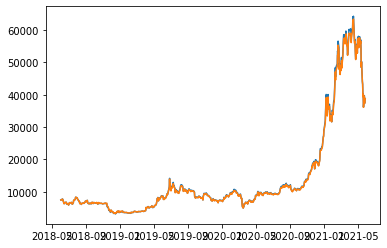

In [623]:
plt.plot(merged.Date, merged.PX_LAST)
plt.plot(merged.Date, merged.loc[:, 'BTC Price'])

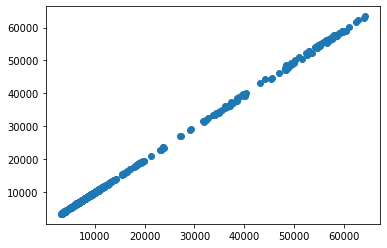

In [624]:
plt.scatter(merged.PX_LAST, merged.loc[:, 'BTC Price'])

In [625]:
merged.loc[:, 'log return future'] = np.log(merged.PX_LAST/merged.PX_LAST.shift(-1))
merged.loc[:, 'log return bitcoin'] = np.log(merged.loc[:, 'BTC Price']/merged.loc[:, 'BTC Price'].shift(-1))

In [626]:
merged = merged.iloc[:-1,:]

In [628]:
rs = merged.loc[:, 'log return bitcoin']
rf = merged.loc[:, 'log return future']

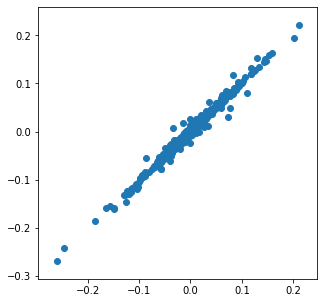

In [629]:
plt.figure(figsize=(5,5))
plt.scatter(rs, rf)

In [630]:
from statsmodels.distributions.empirical_distribution import ECDF

In [631]:
ecdf_rs = ECDF(rs)
ecdf_rf = ECDF(rf)
ecdf_rh = ECDF(rs-rf)

m = min([np.min(rs), np.min(rf)])
M = max([np.max(rs), np.max(rf)])

Text(0, 0.5, 'Future')

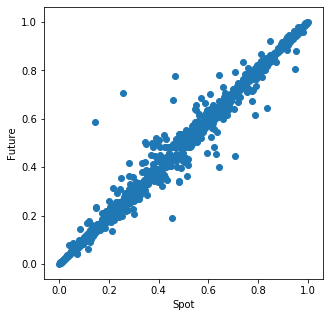

In [632]:
plt.figure(figsize=(5,5))
plt.scatter(ecdf_rs(rs), ecdf_rf(rf))
plt.xlabel('Spot')
plt.ylabel('Future')

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-pack

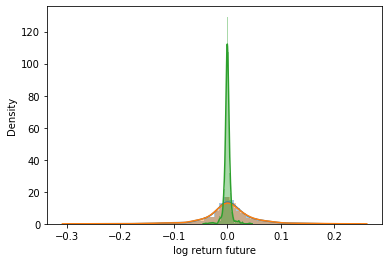

In [633]:
import seaborn as sns
rh = rs-rf

sns.distplot(rs)
sns.distplot(rf)
sns.distplot(rh)

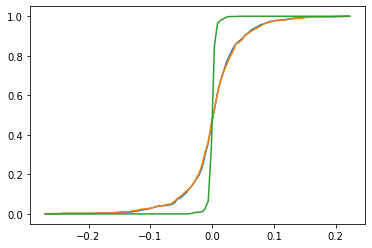

In [634]:
x = np.linspace(m,M,100)
# y = np.linspace(np.min(rh), np.max(rh), 100)

plt.plot(x, ecdf_rs(x))
plt.plot(x, ecdf_rf(x))
plt.plot(x, ecdf_rh(x))

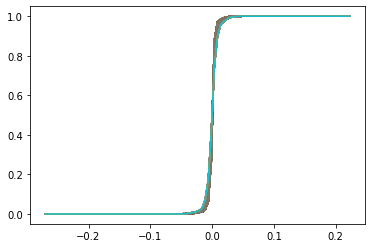

In [635]:
h_arr = np.linspace(0.9,1.1,600)
var_arr = []

for h in h_arr:
    rh = rs - h*rf
    cdf = ECDF(rh)
    var_arr.append(np.var(rh))
    plt.plot(x, cdf(x))

0.9567612687813022


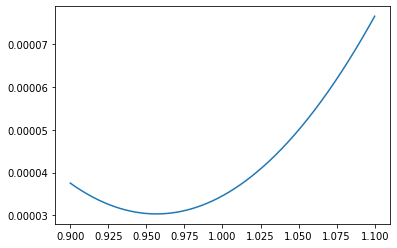

In [636]:
plt.plot(h_arr, var_arr)

h_star = h_arr[np.argmin(var_arr)]
print(h_star)

In [637]:
np.mean(1/(merged.loc[:,'PX_LAST']/merged.loc[:,'BTC Price']))

0.9934540748429471

1.3598028568154298e-06 0.005880858781069327 0.00023122521853316367
9.60112600407219e-05 0.0055103948990359326 0.017423662332715844


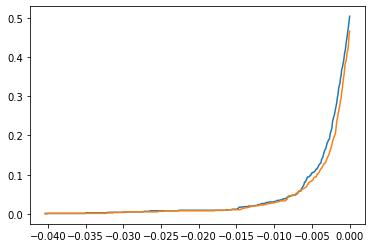

In [638]:
rh = rs - 1*rf
cdf = ECDF(rh)

# x = np.linspace(np.min(rh), np.max(rh), 500)
x = np.linspace(np.min(rh), 0, 500)

plt.plot(x, cdf(x))
print(np.mean(rh), np.std(rh),  np.mean(rh)/np.std(rh))

rh = rs - h_star*rf
cdf = ECDF(rh)
plt.plot(x, cdf(x))
print(np.mean(rh), np.std(rh),  np.mean(rh)/np.std(rh))

In [639]:
merged.to_csv('../data/cleaned_data/BBT_Tiingo.csv')